### Assignment 2: DES Simulation

In [1]:
import numpy as np
import simpy
import random
from scipy.stats import t
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

#### Point 2)

In [2]:
RANDOM_SEED = 42 # seed to ensure reproducipility
SIM_TIME = 10000 # total simulation time
ARRIVAL_RATE = 2 # average rate of arrival (lambda)
SERVICE_RATE = 1 # average rate of service (mu)
NUM_SERVERS = [1, 2, 4] # number of servers
NUM_REPLICATIONS = 50 # number of replications


def service(env, service_rate):
    """Simulate the service of a job by a server.
    
    Inputs:
    - env: the simulation (simpy) environment.
    - service_rate: rate at which the server processes jobs.
    
    Output:
    - env.timeout: time needed to complete the service.
    """
    service_time = random.expovariate(service_rate)
    yield env.timeout(service_time)


def process_job(env, servers, service_rate, waiting_time):
    """Handle the arrival and processing of a job.
    
    Inputs:
    - env: the simulation (simpy) environment.
    - servers: the server resource (simpy) managing the jobs.
    - service_rate: rate at which the server processes jobs.
    - waiting_time: list with the waiting time of processed jobs.

    Output:
    - env.process: a process for handling the job service
    """
    arrival_time = env.now
    with servers.request() as request:
        yield request  # wait until a server is available
        wait_time = env.now - arrival_time
        waiting_time.append(wait_time)  # record the waiting time for the job
        yield env.process(service(env, service_rate))


def arrival_process_fifo(env, arrival_rate, servers, service_rate, waiting_time):
    """Generate new jobs that arrive with an exponential interarrival time.
    
    Inputs:
    - env: the simulation (simpy) environment.
    - arrival_rate: the rate at which jobs arrive.
    - service_rate: rate at which the server processes jobs.
    - waiting_time: list with the waiting time of processed jobs.
    
    Output:
    - env.timeout: interarrival time before the next job
    """
    while True:
        interarrival_time = random.expovariate(arrival_rate)
        yield env.timeout(interarrival_time)
        env.process(process_job(env, servers, service_rate, waiting_time))


def run_simulation(num_servers, arrival_rate, service_rate, sim_time, seed):
    """Run the simulation for a given number of servers.
    
    Inputs:
    - num_servers: number of servers in the simulation
    - arrival_rate: the rate at which jobs arrive.
    - service_rate: rate at which the server processes jobs.
    - sim_time: total simulation time
    - seed: random seed for reproducibility

    Output:
    - average waiting time in the simulation
    """
    random.seed(seed)
    
    env = simpy.Environment()
    servers = simpy.Resource(env, capacity=num_servers)
    
    waiting_time = [] # list to store the waiting times
    
    env.process(arrival_process_fifo(env, arrival_rate, servers, service_rate, waiting_time))
    env.run(until=sim_time)
    
    return np.mean(waiting_time)


def compute_confidence_interval(data, confidence=0.95):
    """Compute the confidence interval for a dataset.
    
    Inputs:
    - data: dataset to compute the confidence interavl for.
    - confidence: the confidence level

    Returns:
    - Mean, lower bound, upper bound of the confidence interval.
    """
    mean = np.mean(data)
    std_error = np.std(data, ddof=1) / np.sqrt(len(data))  # standard error of the mean
    margin = std_error * 1.96  # approximation for 95% CI
    return mean, mean - margin, mean + margin


if __name__ == '__main__':
    print(f"Simulation Time: {SIM_TIME}")
    print(f"Service Rate (μ): {SERVICE_RATE}")
    print(f"Arrival Rate (λ): {ARRIVAL_RATE}")
    print(f"Number of Replications: {NUM_REPLICATIONS}")
    
    # Store results for each server configuration
    all_replications = {}

    for num_servers in NUM_SERVERS:
        replications = []
        
        for i in range(NUM_REPLICATIONS):
            seed = RANDOM_SEED + i  # different seed for each replication
            avg_waiting_time = run_simulation(num_servers, ARRIVAL_RATE, SERVICE_RATE, SIM_TIME, seed)
            replications.append(avg_waiting_time)
        
        mean, lower_bound, upper_bound = compute_confidence_interval(replications)
        
        print(f"\nNumber of Servers: {num_servers}")
        print(f"Mean Waiting Time: {mean:.2f}")
        print(f"95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")
        
        # Store replications for this server
        all_replications[num_servers] = replications

    # Perform pairwise t-tests
    for i, num_servers1 in enumerate(NUM_SERVERS):
        for j, num_servers2 in enumerate(NUM_SERVERS):
            if i < j:  # Only compare each pair once
                data1 = all_replications[num_servers1]
                data2 = all_replications[num_servers2]
                
                t_stat, p_value = ttest_ind(data1, data2, equal_var=False)  # Welch's t-test
                
                print(f"\nT-test between {num_servers1} servers and {num_servers2} servers:")
                print(f"T-statistic: {t_stat:.4f}")
                print(f"P-value: {p_value:.4f}")
                if p_value < 0.05:
                    print("Result: Significant difference (reject null hypothesis).")
                else:
                    print("Result: No significant difference (fail to reject null hypothesis).")


Simulation Time: 10000
Service Rate (μ): 1
Arrival Rate (λ): 2
Number of Replications: 50

Number of Servers: 1
Mean Waiting Time: 2492.46
95% Confidence Interval: (2481.43, 2503.48)

Number of Servers: 2
Mean Waiting Time: 47.36
95% Confidence Interval: (39.79, 54.93)

Number of Servers: 4
Mean Waiting Time: 0.09
95% Confidence Interval: (0.09, 0.09)

T-test between 1 servers and 2 servers:
T-statistic: 358.3214
P-value: 0.0000
Result: Significant difference (reject null hypothesis).

T-test between 1 servers and 4 servers:
T-statistic: 443.1540
P-value: 0.0000
Result: Significant difference (reject null hypothesis).

T-test between 2 servers and 4 servers:
T-statistic: 12.2333
P-value: 0.0000
Result: Significant difference (reject null hypothesis).


Simulation for different ρ values completed.


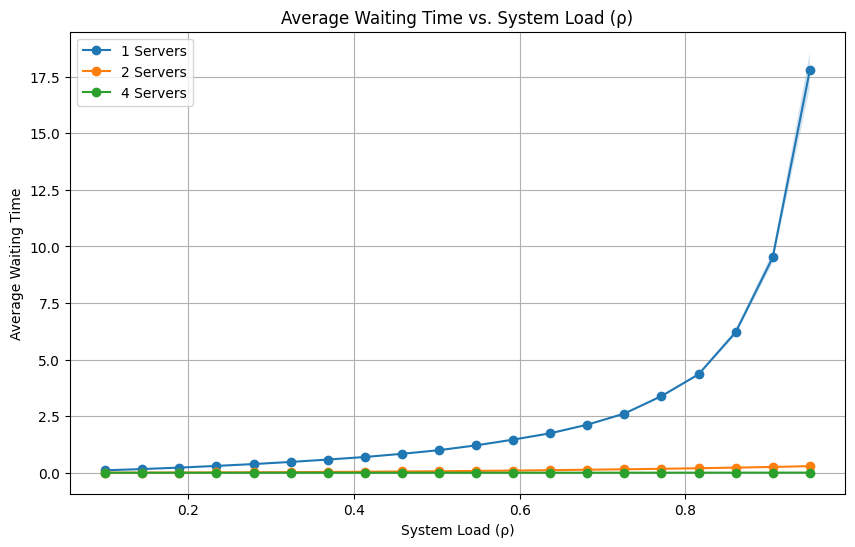

In [3]:
# Plotting the average waiting time for M/M/n systems for varying system loads and number of servers.
RHO_VALUES = np.linspace(0.1, 0.95, 20)  # Varying system load values (ρ)
NUM_SERVERS = [1, 2, 4]  
SIM_TIME = 10000 
NUM_REPLICATIONS = 100  

average_waiting_times = {n: [] for n in NUM_SERVERS}
std_devs = {n: [] for n in NUM_SERVERS}

for rho in RHO_VALUES:
    arrival_rate = rho * SERVICE_RATE  # λ = ρ * (n * μ)
    for n in NUM_SERVERS:
        replications = [
            run_simulation(n, arrival_rate, SERVICE_RATE, SIM_TIME, RANDOM_SEED + i)
            for i in range(NUM_REPLICATIONS)
        ]
        average_waiting_times[n].append(np.mean(replications))
        std_devs[n].append(np.std(replications)) # standard deviations
print("Simulation for different ρ values completed.")

plt.figure(figsize=(10, 6))

for n in NUM_SERVERS:
    mean_waiting_times = np.array(average_waiting_times[n])
    std_errors = np.array(std_devs[n]) / np.sqrt(NUM_REPLICATIONS)  # Standard errors

    plt.plot(RHO_VALUES, mean_waiting_times, label=f'{n} Servers', marker='o')
    plt.fill_between(
        RHO_VALUES,
        mean_waiting_times - std_errors,
        mean_waiting_times + std_errors,
        alpha=0.2
    )

plt.title('Average Waiting Time vs. System Load (ρ)')
plt.xlabel('System Load (ρ)')
plt.ylabel('Average Waiting Time')
plt.legend()
plt.grid()
plt.show()


#### Point 3)

In [4]:
RANDOM_SEED = 42
SIM_TIME = 10000
ARRIVAL_RATE = 2
SERVICE_RATE = 1
NUM_SERVERS = 1
NUM_REPLICATIONS = 100


def process_jobs_sjf(env, queue, waiting_time):
    """Process jobs in the system based on shortest job first (SJF) scheduling.
    
    Inputs:
    - env: the simulation (simpy) environment.
    - queue: priority queue storing jobs with service time as priority.
    - waiting_time: list to store the waiting time of completed jobs.
    """
    while True:
        # Get the next job (shortest service time) from the queue
        priority, (service_time, arrival_time, job_id) = yield queue.get()

        wait_time = env.now - arrival_time
        waiting_time.append(wait_time)

        yield env.timeout(service_time)


def arrival_process_sjf(env, queue, arrival_rate, service_rate):
    """Generate new jobs for SFJ scheduling.
    
    Inputs:
    - env: the simulation (simpy) environment.
    - queue: priority queue storing jobs with service time as priority.
    - arrival_rate: the rate at which jobs arrive.
    - service_rate: rate at which the server processes jobs.
    """
    while True:
        interarrival_time = np.random.exponential(1.0 / arrival_rate)
        yield env.timeout(interarrival_time)

        service_time = np.random.exponential(1.0 / service_rate)
        arrival_time = env.now
        job_id = np.random.randint(0, int(1e6))  # Unique job ID
        job = (service_time, arrival_time, job_id)
        yield queue.put((service_time, job))


def run_simulation(num_servers, arrival_rate, service_rate, sim_time, seed, sjfs=False):
    """Run the simulation for FIFO or SJF scheduling.
    
    Inputs:
    - num_servers: number of servers in the system.
    - arrival_rate: the rate at which jobs arrive.
    - service_rate: rate at which the server processes jobs.
    - sim_time: total simulation time
    - seed: seed for reproducibility
    - sjfs: if False, FIFO scheduling, if True, SJF scheduling.

    Output:
    - average waiting time of jobs in the simulation.
    """
    np.random.seed(seed) 
    random.seed(seed)
    env = simpy.Environment()
    waiting_time = []

    if sjfs:
        # SJF scheduling
        queue = simpy.PriorityStore(env)
        env.process(arrival_process_sjf(env, queue, arrival_rate, service_rate))
        for _ in range(num_servers):
            env.process(process_jobs_sjf(env, queue, waiting_time))
    else:
        # FIFO scheduling
        servers = simpy.Resource(env, capacity=num_servers)
        env.process(arrival_process_fifo(env, arrival_rate, servers, service_rate, waiting_time))

    env.run(until=sim_time)
    return np.mean(waiting_time)


if __name__ == '__main__':
    print(f"Simulation Time: {SIM_TIME}")
    print(f"Service Rate (μ): {SERVICE_RATE}")
    print(f"Arrival Rate (λ): {ARRIVAL_RATE}")
    print(f"Number of Replications: {NUM_REPLICATIONS}")
    
    # Store results for FIFO and SJF
    all_replications = {'FIFO': [], 'SJF': []}

    # Perform simulations for FIFO and SJF
    for sjfs in [False, True]:
        scheduling_type = 'SJF' if sjfs else 'FIFO'
        print(f"\n--- {scheduling_type} Scheduling ---")
        
        replications1 = []
        for i in range(NUM_REPLICATIONS):
            seed = RANDOM_SEED + i  # different seed for each replication
            avg_waiting_time = run_simulation(NUM_SERVERS, ARRIVAL_RATE, SERVICE_RATE, SIM_TIME, seed, sjfs=sjfs)
            replications1.append(avg_waiting_time)

        mean, lower_bound, upper_bound = compute_confidence_interval(replications1)
        
        print(f"Mean Waiting Time: {mean:.2f}")
        print(f"95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")
        
        # Store replications for FIFO and SJF
        all_replications[scheduling_type] = replications1

    # Pairwise t-test comparison between FIFO and SJF
    fifo_replications = all_replications['FIFO']
    sjf_replications = all_replications['SJF']

    t_stat, p_value = ttest_ind(fifo_replications, sjf_replications, equal_var=False)  # Welch's t-test
    print("\n--- T-Test Comparison: FIFO vs. SJF ---")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("Result: Significant difference (reject null hypothesis).")
    else:
        print("Result: No significant difference (fail to reject null hypothesis).")

Simulation Time: 10000
Service Rate (μ): 1
Arrival Rate (λ): 2
Number of Replications: 100

--- FIFO Scheduling ---
Mean Waiting Time: 2496.00
95% Confidence Interval: (2487.42, 2504.58)

--- SJF Scheduling ---
Mean Waiting Time: 15.68
95% Confidence Interval: (14.82, 16.53)

--- T-Test Comparison: FIFO vs. SJF ---
T-statistic: 563.5179
P-value: 0.0000
Result: Significant difference (reject null hypothesis).


Comparison for FIFO vs. SJF completed.


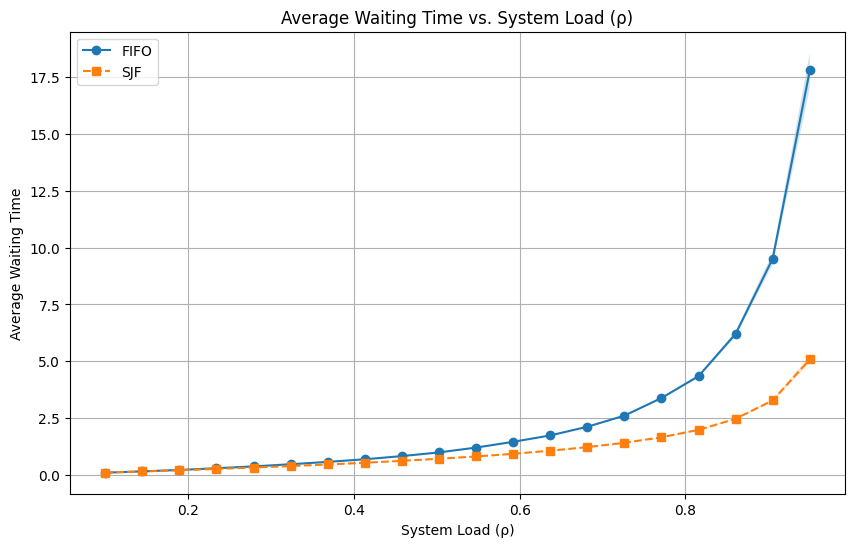

In [5]:
# Plotting the average waiting time for M/M/1 system with SJF and FIFO scheduing, for varying system loads.
SIM_TIME = 10000  
RHO_VALUES = np.linspace(0.1, 0.95, 20)  # System load values (ρ)
NUM_REPLICATIONS = 100
SERVICE_RATE = 1

# Store results for FIFO and SJF
fifo_waiting_times = []
sjfs_waiting_times = []

for rho in RHO_VALUES:
    arrival_rate = rho * SERVICE_RATE  # λ = ρ * μ
    
    # Waiting times for FIFO
    fifo_replications = [
        run_simulation(1, arrival_rate, SERVICE_RATE, SIM_TIME, RANDOM_SEED + i, sjfs=False)
        for i in range(NUM_REPLICATIONS)
    ]
    fifo_waiting_times.append((np.mean(fifo_replications), np.std(fifo_replications)))

    # Waiting times for SJF
    sjfs_replications = [
        run_simulation(1, arrival_rate, SERVICE_RATE, SIM_TIME, RANDOM_SEED + i, sjfs=True)
        for i in range(NUM_REPLICATIONS)
    ]
    sjfs_waiting_times.append((np.mean(sjfs_replications), np.std(sjfs_replications)))

print("Comparison for FIFO vs. SJF completed.")

# Plot the results for FIFO and SJF
fifo_means = [x[0] for x in fifo_waiting_times]
fifo_stds = [x[1] / np.sqrt(NUM_REPLICATIONS) for x in fifo_waiting_times]  # Standard errors

sjfs_means = [x[0] for x in sjfs_waiting_times]
sjfs_stds = [x[1] / np.sqrt(NUM_REPLICATIONS) for x in sjfs_waiting_times]  # Standard errors

plt.figure(figsize=(10, 6))

# Plot FIFO
plt.plot(RHO_VALUES, fifo_means, label='FIFO', marker='o')
plt.fill_between(
    RHO_VALUES,
    np.array(fifo_means) - np.array(fifo_stds),
    np.array(fifo_means) + np.array(fifo_stds),
    alpha=0.2
)

# Plot SJF
plt.plot(RHO_VALUES, sjfs_means, label='SJF', marker='s', linestyle='--')
plt.fill_between(
    RHO_VALUES,
    np.array(sjfs_means) - np.array(sjfs_stds),
    np.array(sjfs_means) + np.array(sjfs_stds),
    alpha=0.2
)

plt.title('Average Waiting Time vs. System Load (ρ)')
plt.xlabel('System Load (ρ)')
plt.ylabel('Average Waiting Time')
plt.legend()
plt.grid()
plt.show()


 #### Point 4)

In [6]:
# Constants
NUM_SERVERS = [1, 2, 4]
SIM_TIME = 10000
NUM_REPLICATIONS = 50
SERVICE_RATE = 1.0  # μ for deterministic service


def arrival_process_md(env, servers, arrival_rate, service_rate, waiting_time, np_random):
    """
    Generate new jobs with deterministic service times for M/D/1 or M/D/n systems.

    Inputs:
    - env: the simulation (simpy) environment.
    - servers: a simpy.Resource representing the servers in the system.
    - arrival_rate: rate at which jobs arrive (λ).
    - service_rate: rate at which the server processes jobs (μ).
    - waiting_time: list to store the waiting times of completed jobs.
    - np_random: numpy random state for reproducibility.

    This function simulates the arrival process, where jobs have exponentially distributed 
    interarrival times and deterministic service times (1 / service_rate).
    """
    while True:
        # Generate interarrival time
        interarrival_time = np_random.exponential(1.0 / arrival_rate)
        yield env.timeout(interarrival_time)

        # Deterministic service time (1 / service rate)
        service_time = 1.0 / service_rate
        arrival_time = env.now

        def service(env, service_time, arrival_time):
            """
            Simulate the service process for a single job.

            Inputs:
            - env: the simulation (simpy) environment.
            - service_time: deterministic service time of the job.
            - arrival_time: the time at which the job arrived.
            """
            with servers.request() as request:
                # Wait for a server to be available
                yield request

                # Record waiting time
                wait_time = env.now - arrival_time
                waiting_time.append(wait_time)

                # Simulate the service time
                yield env.timeout(service_time)

        # Start the service process
        env.process(service(env, service_time, arrival_time))


def run_md_simulation(num_servers, arrival_rate, service_rate, sim_time, seed):
    """
    Run the M/D/1 or M/D/n simulation.
    """
    np_random = np.random.RandomState(seed)
    env = simpy.Environment()

    # List to store waiting times
    waiting_time = []

    # Create a resource to represent the servers
    servers = simpy.Resource(env, capacity=num_servers)
    env.process(arrival_process_md(env, servers, arrival_rate, service_rate, waiting_time, np_random))

    # Run the simulation
    env.run(until=sim_time)

    # Return the average waiting time
    return np.mean(waiting_time)


if __name__ == '__main__':
    """
    Main program to simulate M/D/1 and M/D/n queues and compute confidence intervals for waiting times.
    """
    print("\n--- M/D/1 and M/D/n Queues ---")
    for num_servers in NUM_SERVERS:
        replications = []

        for i in range(NUM_REPLICATIONS):
            seed = RANDOM_SEED + i
            avg_waiting_time = run_md_simulation(num_servers, ARRIVAL_RATE, SERVICE_RATE, SIM_TIME, seed)
            replications.append(avg_waiting_time)

        # Compute confidence interval
        mean, lower_bound, upper_bound = compute_confidence_interval(replications)

        print(f"\nNumber of Servers: {num_servers} (M/D/{num_servers})")
        print(f"Mean Waiting Time: {mean:.2f}")
        print(f"95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")


--- M/D/1 and M/D/n Queues ---

Number of Servers: 1 (M/D/1)
Mean Waiting Time: 2503.28
95% Confidence Interval: (2495.54, 2511.02)

Number of Servers: 2 (M/D/2)
Mean Waiting Time: 39.12
95% Confidence Interval: (32.30, 45.94)

Number of Servers: 4 (M/D/4)
Mean Waiting Time: 0.05
95% Confidence Interval: (0.05, 0.05)


In [7]:
def arrival_process_hyperexp(env, servers, arrival_rate, waiting_time, np_random):
    """Generate new jobs with hyperexponential service times."""
    while True:
        # Generate interarrival time
        interarrival_time = np_random.exponential(1.0 / arrival_rate)
        yield env.timeout(interarrival_time)

        # Hyperexponential service time
        if np_random.uniform() < 0.75:  # 75% jobs with avg service time = 1.0
            service_time = np_random.exponential(1.0)
        else:  # 25% jobs with avg service time = 5.0
            service_time = np_random.exponential(5.0)

        arrival_time = env.now

        def service(env, service_time, arrival_time):
            with servers.request() as request:
                # Wait for a server to be available
                yield request

                # Record waiting time
                wait_time = env.now - arrival_time
                waiting_time.append(wait_time)

                # Simulate the service time
                yield env.timeout(service_time)

        # Start the service process
        env.process(service(env, service_time, arrival_time))


def run_hyperexp_simulation(num_servers, arrival_rate, sim_time, seed):
    """Run the M/H2/1 or M/H2/n simulation."""
    np_random = np.random.RandomState(seed)
    env = simpy.Environment()

    # List to store waiting times
    waiting_time = []

    # Create a resource to represent the servers
    servers = simpy.Resource(env, capacity=num_servers)
    env.process(arrival_process_hyperexp(env, servers, arrival_rate, waiting_time, np_random))

    # Run the simulation
    env.run(until=sim_time)

    # Return the average waiting time
    return np.mean(waiting_time)


if __name__ == '__main__':
    print("\n--- M/H2/1 and M/H2/n Queues ---")
    for num_servers in NUM_SERVERS:
        replications = []

        for i in range(NUM_REPLICATIONS):
            seed = RANDOM_SEED + i
            avg_waiting_time = run_hyperexp_simulation(num_servers, ARRIVAL_RATE, SIM_TIME, seed)
            replications.append(avg_waiting_time)

        # Compute confidence interval
        mean, lower_bound, upper_bound = compute_confidence_interval(replications)

        print(f"\nNumber of Servers: {num_servers} (M/H2/{num_servers})")
        print(f"Mean Waiting Time: {mean:.2f}")
        print(f"95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")



--- M/H2/1 and M/H2/n Queues ---

Number of Servers: 1 (M/H2/1)
Mean Waiting Time: 3735.92
95% Confidence Interval: (3715.63, 3756.20)

Number of Servers: 2 (M/H2/2)
Mean Waiting Time: 2480.53
95% Confidence Interval: (2461.15, 2499.91)

Number of Servers: 4 (M/H2/4)
Mean Waiting Time: 71.22
95% Confidence Interval: (59.38, 83.06)


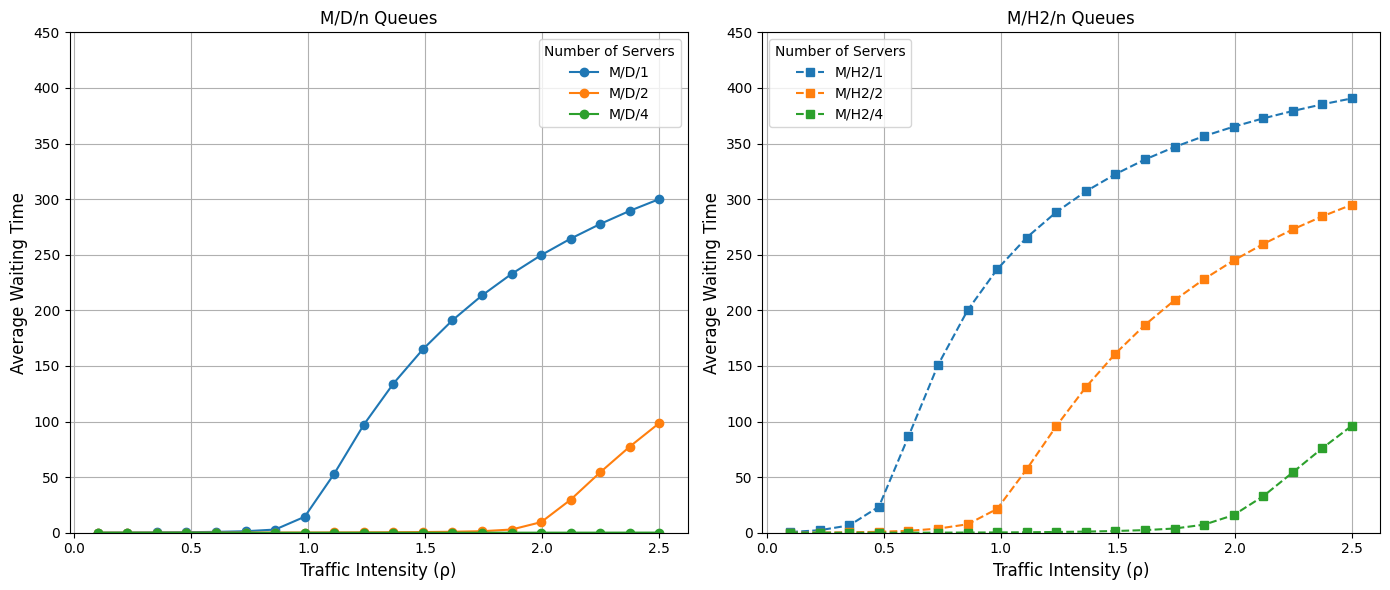

In [12]:
# Constants
RANDOM_SEED = 42  # Define a seed for reproducibility
RHO_VALUES = np.linspace(0.1, 2.5, 20)  # Vary ρ for a range of values
SIM_TIME = 1000
NUM_REPLICATIONS = 10
SERVICE_RATE = 1.0  # Service rate μ for both models
NUM_SERVERS = [1, 2, 4]  # Different number of servers to test

# Function to compute confidence intervals (95% CI)
def compute_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std_error = np.std(data) / np.sqrt(len(data))
    z_score = 1.96  # For 95% confidence
    margin_of_error = z_score * std_error
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return mean, lower_bound, upper_bound


# Function to run M/D/n simulation (deterministic service times)
def run_md_simulation(num_servers, rho, service_rate, sim_time, seed):
    np_random = np.random.RandomState(seed)
    env = simpy.Environment()
    waiting_time = []
    arrival_rate = rho * service_rate  # Calculate λ from ρ and μ
    servers = simpy.Resource(env, capacity=num_servers)
    env.process(arrival_process_md(env, servers, arrival_rate, service_rate, waiting_time, np_random))
    env.run(until=sim_time)
    return np.mean(waiting_time)


# Function to run M/H2/n simulation (hyperexponential service times)
def run_hyperexp_simulation(num_servers, rho, sim_time, seed):
    np_random = np.random.RandomState(seed)
    env = simpy.Environment()
    waiting_time = []
    arrival_rate = rho * SERVICE_RATE  # Calculate λ from ρ and μ
    servers = simpy.Resource(env, capacity=num_servers)
    env.process(arrival_process_hyperexp(env, servers, arrival_rate, waiting_time, np_random))
    env.run(until=sim_time)
    return np.mean(waiting_time)


# Plotting function for average waiting time vs. rho for both queue configurations
def plot_avg_waiting_times():
    # Create two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # M/D/n queue (deterministic service times)
    for num_servers in NUM_SERVERS:
        md_waiting_times = []

        # Run the simulations for each rho
        for rho in RHO_VALUES:
            md_replications = []

            # Run multiple replications for M/D/n
            for i in range(NUM_REPLICATIONS):
                seed = RANDOM_SEED + i
                md_wait = run_md_simulation(num_servers, rho, SERVICE_RATE, SIM_TIME, seed)
                md_replications.append(md_wait)

            # Compute average waiting time for M/D/n
            md_mean, _, _ = compute_confidence_interval(md_replications)

            md_waiting_times.append(md_mean)

        # Plot the M/D/n results
        ax1.plot(RHO_VALUES, md_waiting_times, label=f'M/D/{num_servers}', marker='o', linestyle='-')

    ax1.set_title('M/D/n Queues')
    ax1.set_xlabel('Traffic Intensity (ρ)', size=12)
    ax1.set_ylabel('Average Waiting Time', size=12)
    ax1.legend(title="Number of Servers")
    ax1.grid(True)

    # M/H2/n queue (hyperexponential service times)
    for num_servers in NUM_SERVERS:
        hyperexp_waiting_times = []

        # Run the simulations for each rho
        for rho in RHO_VALUES:
            hyperexp_replications = []

            # Run multiple replications for M/H2/n
            for i in range(NUM_REPLICATIONS):
                seed = RANDOM_SEED + i
                hyperexp_wait = run_hyperexp_simulation(num_servers, rho, SIM_TIME, seed)
                hyperexp_replications.append(hyperexp_wait)

            # Compute average waiting time for M/H2/n
            hyperexp_mean, _, _ = compute_confidence_interval(hyperexp_replications)

            hyperexp_waiting_times.append(hyperexp_mean)

        # Plot the M/H2/n results
        ax2.plot(RHO_VALUES, hyperexp_waiting_times, label=f'M/H2/{num_servers}', marker='s', linestyle='--')

    ax2.set_title('M/H2/n Queues')
    ax2.set_xlabel('Traffic Intensity (ρ)', size=12)
    ax2.set_ylabel('Average Waiting Time', size=12)
    ax2.legend(title="Number of Servers")
    ax2.grid(True)

    y_min = 0
    y_max = 450
    ax1.set_ylim([y_min, y_max])
    ax2.set_ylim([y_min, y_max])

    # Display the plots
    plt.tight_layout()
    plt.show()


# Run the plotting function
plot_avg_waiting_times()
